In [1]:
import os
import shutil
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.18.0


In [7]:
# nutrition_data = pd.read_csv('nutrition_dpe.csv')
# nutrition_data.head()

In [2]:
# Path ke folder dataset
image_folder_path = './food_dataset'

# Fungsi untuk menghitung jumlah gambar
def count_images_for_category(category_folder):
    """Count images in a given category folder."""
    images = [f for f in os.listdir(category_folder) if f.endswith(('.jpeg', '.jpg', '.png'))]
    print(f"There are {len(images)} images in the category '{os.path.basename(category_folder)}'.")

# Ambil semua sub-folder sebagai kategori makanan
categories = [os.path.join(image_folder_path, d) for d in os.listdir(image_folder_path) if os.path.isdir(os.path.join(image_folder_path, d))]

# Hitung jumlah gambar untuk setiap kategori
for category_folder in categories:
    count_images_for_category(category_folder)

There are 40 images in the category 'anggur'.
There are 35 images in the category 'apel'.
There are 50 images in the category 'ayam'.
There are 125 images in the category 'bakso'.
There are 29 images in the category 'bakwan'.
There are 25 images in the category 'bubur'.
There are 19 images in the category 'burger'.
There are 30 images in the category 'capcay'.
There are 40 images in the category 'cumi'.
There are 30 images in the category 'durian'.
There are 30 images in the category 'es krim'.
There are 25 images in the category 'gudeg'.
There are 100 images in the category 'ikan goreng'.
There are 30 images in the category 'jeruk'.
There are 25 images in the category 'kacang'.
There are 30 images in the category 'kentang'.
There are 23 images in the category 'kerupuk'.
There are 40 images in the category 'kopi'.
There are 100 images in the category 'lele goreng'.
There are 100 images in the category 'pempek'.
There are 100 images in the category 'sate'.
There are 100 images in the ca

In [9]:
# print(nutrition_data.info())

# if nutrition_data.isnull().sum().any():
#     print("Data memiliki nilai kosong. Mengisi nilai kosong dengan 0...")
#     nutrition_data.fillna(0, inplace=True)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# columns_to_normalize = ['calories', 'proteins', 'fat', 'carbohydrate']
# nutrition_data[columns_to_normalize] = scaler.fit_transform(nutrition_data[columns_to_normalize])


# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# nutrition_data['label'] = label_encoder.fit_transform(nutrition_data['name'])

# X = nutrition_data[columns_to_normalize].values  # Fitur: nutrisi
# y = nutrition_data['label'].values               # Label: nama makanan dalam format numerik

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("Data setelah preprocessing:")
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

# import joblib
# joblib.dump(label_encoder, 'label_encoder.pkl')
# print("Label encoder disimpan sebagai 'label_encoder.pkl'")

In [3]:
# Root directory for split data
root_dir = './food_dataset'

# Buat folder train dan validation jika belum ada
train_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [4]:
# Function to create subdirectories for each food category
def create_train_val_dirs(food_name):
    train_food_dir = os.path.join(train_dir, food_name)
    validation_food_dir = os.path.join(validation_dir, food_name)

    os.makedirs(train_food_dir, exist_ok=True)
    os.makedirs(validation_food_dir, exist_ok=True)

# Create directories for all food categories
for category in categories:
    create_train_val_dirs(category)

In [5]:
# Function to split data into training and validation sets
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE=0.8):
    """
    Splits images in SOURCE_DIR into TRAINING_DIR and VALIDATION_DIR.
    """
    # List all image files in the source directory
    image_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith(('.jpeg', '.jpg', '.png'))]

    # Shuffle and split data
    random.shuffle(image_files)
    split_index = int(len(image_files) * SPLIT_SIZE)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    # Copy files to respective directories
    for file_name in train_files:
        src = os.path.join(SOURCE_DIR, file_name)
        dst = os.path.join(TRAINING_DIR, file_name)
        shutil.copyfile(src, dst)

    for file_name in val_files:
        src = os.path.join(SOURCE_DIR, file_name)
        dst = os.path.join(VALIDATION_DIR, file_name)
        shutil.copyfile(src, dst)

In [6]:
import os
import shutil
import numpy as np

# Fungsi untuk memindahkan data ke folder training dan validation
def split_data_general(image_root, train_dir, validation_dir, split_size=0.8):
    # Ambil semua kategori dari folder root
    categories = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]

    for category in categories:
        source_dir = os.path.join(image_root, category)
        train_food_dir = os.path.join(train_dir, category)
        validation_food_dir = os.path.join(validation_dir, category)

        # Pastikan folder train dan validation untuk kategori ini ada
        os.makedirs(train_food_dir, exist_ok=True)
        os.makedirs(validation_food_dir, exist_ok=True)

        # Ambil semua file dari kategori ini
        all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
        
        if not all_files:
            print(f"Warning: Tidak ada file di kategori '{category}'!")
            continue
        
        # Shuffle dan split file
        np.random.shuffle(all_files)
        split_index = int(len(all_files) * split_size)
        train_files = all_files[:split_index]
        val_files = all_files[split_index:]

        # Salin file ke folder training dan validation
        for file in train_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(train_food_dir, file))
        
        for file in val_files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(validation_food_dir, file))

        # Print status
        print(f"Kategori '{category}':")
        print(f"  - {len(train_files)} file dipindahkan ke folder training")
        print(f"  - {len(val_files)} file dipindahkan ke folder validation")

# Path folder dataset
image_root = './food_dataset'
train_dir = './food_dataset/training'
validation_dir = './food_dataset/validation'

# Jalankan proses split
split_data_general(image_root, train_dir, validation_dir, split_size=0.8)

Kategori 'anggur':
  - 64 file dipindahkan ke folder training
  - 16 file dipindahkan ke folder validation
Kategori 'apel':
  - 56 file dipindahkan ke folder training
  - 14 file dipindahkan ke folder validation
Kategori 'ayam':
  - 80 file dipindahkan ke folder training
  - 20 file dipindahkan ke folder validation
Kategori 'bakso':
  - 120 file dipindahkan ke folder training
  - 30 file dipindahkan ke folder validation
Kategori 'bakwan':
  - 41 file dipindahkan ke folder training
  - 11 file dipindahkan ke folder validation
Kategori 'bubur':
  - 40 file dipindahkan ke folder training
  - 10 file dipindahkan ke folder validation
Kategori 'burger':
  - 35 file dipindahkan ke folder training
  - 9 file dipindahkan ke folder validation
Kategori 'capcay':
  - 48 file dipindahkan ke folder training
  - 12 file dipindahkan ke folder validation
Kategori 'cumi':
  - 64 file dipindahkan ke folder training
  - 16 file dipindahkan ke folder validation
Kategori 'durian':
  - 47 file dipindahkan ke

**Image Augmentation**

In [7]:
from PIL import Image
import os

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Validasi format gambar
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image file: {file_path}. Removing.")
                os.remove(file_path)

# Validasi folder training dan validation
validate_images('./food_dataset/training')
validate_images('./food_dataset/validation')

Corrupt image file: ./food_dataset/training\anggur\anggur_test (1).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_test (2).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_test (3).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_test (5).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (1).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (11).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (12).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (13).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (14).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (15).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (16).txt. Removing.
Corrupt image file: ./food_dataset/training\anggur\anggur_train (17).txt. Removing.
C

train_generator tidak ditemukan, mendefinisikan ulang...
Found 1419 images belonging to 28 classes.


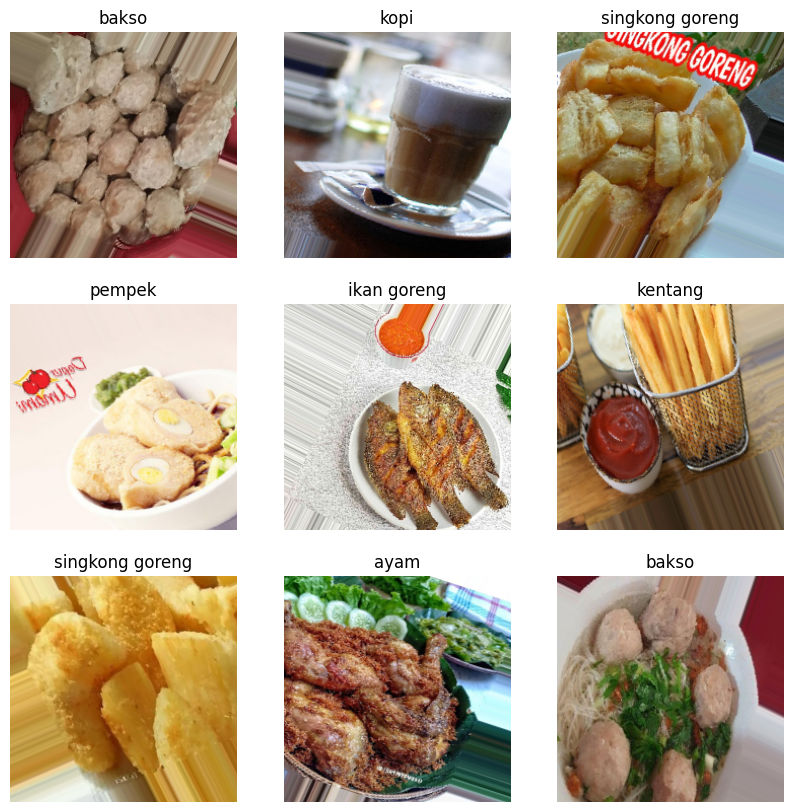

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Jika `train_generator` belum didefinisikan, definisikan ulang
if 'train_generator' not in globals():
    print("train_generator tidak ditemukan, mendefinisikan ulang...")
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    train_generator = train_datagen.flow_from_directory(
        './food_dataset/training',  # Ganti dengan path dataset Anda
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

# Ambil batch pertama dari train_generator
images, labels = next(train_generator)

# Class names dari indeks di train_generator
class_names = list(train_generator.class_indices.keys())

# Plot 9 gambar pertama
plt.figure(figsize=(10, 10))
num_images = min(len(images), 9)  # Plot hanya sebanyak jumlah gambar yang tersedia
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])  # Menampilkan label
    plt.axis("off")
plt.show()

**Transfer Learning**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model without top (fully connected layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set the base model layers to non-trainable
base_model.trainable = False

# Create the model using Functional API
inputs = layers.Input(shape=(224, 224, 3))  # Input layer
x = base_model(inputs, training=False)  # Feature extraction using the base model
x = layers.GlobalAveragePooling2D()(x)  # Pooling to reduce spatial dimensions
x = layers.Dense(128, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout for regularization
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # Output layer

# Define the final model
model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,564 (9.25 MB)

 Trainable params: 167,580 (654.61 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisikan train_datagen
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisasi piksel
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Definisikan validation_datagen
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # Normalisasi piksel tanpa augmentasi
)

# Generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    './food_dataset/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Generator untuk data validasi
validation_generator = validation_datagen.flow_from_directory(
    './food_dataset/validation',  # Path ke folder data validasi
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1419 images belonging to 28 classes.
Found 698 images belonging to 28 classes.


**Develop Model**

In [11]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Callback untuk menghentikan pelatihan
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        """
        Menghentikan pelatihan jika akurasi validasi >= 86% dan loss validasi < 0.5
        """
        acc_condition = logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.86
        loss_condition = logs.get('val_loss') is not None and logs.get('val_loss') < 0.5
        if acc_condition and loss_condition:
            print("\nValidasi Loss < 0.5 dan Validasi Akurasi >= 86%, menghentikan pelatihan!")
            self.model.stop_training = True

In [12]:
# Model checkpoint untuk menyimpan bobot terbaik
model_ckpt_path = "callback_finetune_model_checkpoints/cp_best.weights.h5"  # Ekstensi sesuai format
callback_model_checkpoint = ModelCheckpoint(
    model_ckpt_path,
    monitor="val_accuracy",  # Berdasarkan validasi akurasi
    save_best_only=True,  # Simpan bobot terbaik
    save_weights_only=True,  # Hanya bobot, bukan model
    verbose=1
)

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_model():
    # Base model tanpa top layers
    feature_extractor = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    feature_extractor.trainable = False  # Freeze layer awal

    # Model Sequential
    model = Sequential([
        feature_extractor,  # Feature extractor
        GlobalAveragePooling2D(),  # Pooling
        Dense(512, activation='relu', name='Layer_Dense_512'),
        Dense(256, activation='relu', name='Layer_Dense_256'),
        Dense(128, activation='relu', name='Layer_Dense_128'),
        Dropout(0.5, name='Layer_Dropout_0.5_1'),  # Dropout untuk regularisasi
        Dense(len(train_generator.class_indices), activation='softmax', name='Layer_Dense_Output')  # Output layer
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Buat model
model = create_model()

# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    filepath="food_model_mobilenetv2_best.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Callback untuk menghentikan pelatihan dini
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [16]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Menyimpan model
model.save('food_classification_model.keras')

Epoch 1/10
13/45 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4032 - loss: 2.0686

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: image file is truncated (2 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py", line 2079, in resize
    self.load()

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\ImageFile.py", line 254, in load
    raise OSError(

OSError: image file is truncated (2 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_11382]

**try again**

In [39]:
# Fungsi untuk memeriksa gambar rusak
def validate_images(directory):
    corrupt_images = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verifikasi file gambar
                except Exception as e:
                    corrupt_images.append(file_path)
                    print(f"Gambar rusak ditemukan: {file_path}")
    return corrupt_images

In [40]:
# Modifikasi ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [54]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Fungsi untuk melewati gambar yang rusak
def safe_load_img(filepath, target_size):
    try:
        img = load_img(filepath, target_size=target_size)
        return img_to_array(img)
    except Exception as e:
        print(f"Warning: Skipping corrupted image at {filepath}. Error: {e}")
        return np.zeros((target_size[0], target_size[1], 3))  # Gambar dummy

# Data generator dengan preprocessing function untuk aman
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: safe_load_img(x, target_size=(224, 224))
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: safe_load_img(x, target_size=(224, 224))
)

In [55]:
# Debugging batch pertama
try:
    images, labels = next(train_generator)
    print("Batch pertama berhasil di-load!")
except Exception as e:
    print(f"Error pada batch pertama: {e}")

Batch pertama berhasil di-load!


In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint(
    './best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Melatih model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Simpan model akhir
model.save('./final_model.keras')
print("Model berhasil disimpan!")

Epoch 1/20
 80/172 ━━━━━━━━━━━━━━━━━━━━ 30s 328ms/step - accuracy: 0.7543 - loss: 0.8109

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: image file is truncated (2 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py", line 2079, in resize
    self.load()

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\ImageFile.py", line 254, in load
    raise OSError(

OSError: image file is truncated (2 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_33953]

**try again**

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing function untuk memverifikasi gambar
def preprocess_and_verify(img):
    try:
        # Pastikan gambar valid
        tf.debugging.assert_all_finite(img, "Corrupt image detected!")
        return img
    except Exception as e:
        print(f"Skipping corrupt image. Error: {e}")
        return tf.zeros_like(img)  # Placeholder gambar

# ImageDataGenerator dengan preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_and_verify  # Verifikasi gambar
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_and_verify  # Verifikasi gambar
)

In [61]:
train_generator = train_datagen.flow_from_directory(
    './food_dataset/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    './food_dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1375 images belonging to 28 classes.
Found 521 images belonging to 28 classes.


In [62]:
try:
    images, labels = next(train_generator)
    print("Batch pertama berhasil diproses!")
except Exception as e:
    print(f"Error di batch pertama: {e}")

Batch pertama berhasil diproses!


In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint(
    './best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Latih model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Simpan model akhir
model.save('./final_model.keras')
print("Model berhasil disimpan!")

Epoch 1/20
33/43 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7716 - loss: 0.7145

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: image file is truncated (2 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py", line 2079, in resize
    self.load()

  File "C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\ImageFile.py", line 254, in load
    raise OSError(

OSError: image file is truncated (2 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_33953]